## Section Two: Implementing From Scratch
In this section of the project, we are asked to implement an HMM model from scratch. A notebook file containing the necessary incomplete codes for implementing this model has been uploaded. By completing the different sections of this file, we will eventually achieve a HMM model. Then we train the final models on the given data and finally analyze the results with different criteria introduced in the evaluation and analysis section.



### Initializing
Here, we import the necessary libraries that we're going to work with. After that, we complete the given class *HMM* and debug it, so it can be used later.

In [32]:
import numpy as np
import scipy.stats as st

from python_speech_features import mfcc
from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import random

In [33]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = observation_matrix[:, t] * self.initial_prob.ravel()
            else:
                alpha[:, t] = observation_matrix[:, t] * np.dot(self.transition_matrix.T, alpha[:, t - 1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.transition_matrix, (observation_matrix[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mean[:, s].T, cov=self.covariances[:, :, s].T)

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = self.transition_matrix * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)

        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0]
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


### Reading Audio Files and Training the Models
In this part, we create our own code, which is mostly copied from *Section One*. We read all 400 audio files first, and extract their MFCC signals as we did before. After that, we shuffle the obtained list of MFCC signals for better mixing. This is optional and might not have noticeable impact on the results. Finally, iterating on the 4 genres we have, we develop 4 HMM models, one for each genre.

In [34]:
'''
Iterate through each unique genre in the training data;
extract features from the audio files, and train a HMM for
each genre, storing the trained models in the hmm_models list.
'''

# Define the number of musical instances for each genre
n_instances = 100

# Define the list of genres
genres = ['blues', 'hiphop', 'pop', 'metal']

# Define the list of filenames
filenames = {genre:[] for genre in genres}
for genre in genres:
    for i in range(n_instances):
        if i < 10:
            filenames[genre].append(f'data/{genre}/{genre}.0000{i}.wav')
        else:
            filenames[genre].append(f'data/{genre}/{genre}.000{i}.wav')


# Define the list of MFCCs
mfccs = {genre:[] for genre in genres}
for genre, filename in filenames.items():
    for i in range(n_instances):
        # Load the audio file
        rate, signal = wavfile.read(filename[i])

        # Extract the MFCCs
        mfcc_feat = mfcc(signal, rate, nfft=1024)

        # Normalization
        mfcc_feat /= np.amax(mfcc_feat)

        # Append the MFCCs to the list
        mfccs[genre].append(mfcc_feat.T)

# Shuffle the MFCC instances (arbitrarily)
for genre in genres:
    random.shuffle(mfccs[genre])
    
# Define the variable in which the trained models are going to be stored
hmm_models = {}

# Define the number of hidden states for each genre
n_states = {'blues': 4, 'hiphop': 5, 'pop': 6, 'metal': 7}

for genre in genres:
    hmm_model = None
        
    X = np.array([])
    for i in range(n_instances - 20):
        data = mfccs[genre][i]
        if len(X) == 0:
            X = data
        else:
            X = np.append(X, data, axis=1)            

    hmm_model = HMM(n_states[genre])
    hmm_model.train(X)
    hmm_models[genre] = hmm_model



### Testing
Here, we check our algorithm's predictions on the remaining test files (which forms 20% of the given audio files), and calculate its efficiency. For each instance, it prints the predicted genre and in the end, prints the accuracy of the algorithm's estimation. Here's a result:  
 
|                                                 |                                                 |
| ----------------------------------------------- | ----------------------------------------------- |
| ![Alt text](<Screenshot 2023-12-08 041248.png>) | ![Alt text](<Screenshot 2023-12-08 041327.png>) |
| ![Alt text](<Screenshot 2023-12-08 041347.png>) | ![Alt text](<Screenshot 2023-12-08 041407.png>) |

In [35]:
'''
In this section, iterate through the audio files, extract
features, and use the trained HMMs to predict the genre
for each audio file.
'''

real_lbl = []
predicted_lbl = []

labels = {genre:[] for genre in genres}  
for genre in genres:
    true = 0
    print(f'----------- {genre} -----------')
    for i in range(n_instances-20, n_instances):
        print(i, end='\t')
        test = mfccs[genre][i]
        B = hmm_models['blues'].score(test)
        H = hmm_models['hiphop'].score(test)
        P = hmm_models['pop'].score(test)
        M = hmm_models['metal'].score(test)
        prediction = max(B, H, P, M)

        if prediction == B:
            print('predicted genre is Blues')
            predicted_lbl.append('blues')
            true = true+1 if genre == 'blues' else true
        elif prediction == H:
            print('predicted genre is Hiphop')
            predicted_lbl.append('hiphop')
            true = true+1 if genre == 'hiphop' else true
        elif prediction == P:
            print('predicted genre is Pop')
            predicted_lbl.append('pop')
            true = true+1 if genre == 'pop' else true
        elif prediction == M:
            print('predicted genre is Metal')
            predicted_lbl.append('metal')
            true = true+1 if genre == 'metal' else true

        real_lbl.append(genre)

    print(f'This algorithm predicted the genre of unseen {genre} musics with an accuracy of {true/20*100:.1f}% \n')

        


----------- blues -----------
80	predicted genre is Blues
81	predicted genre is Blues
82	predicted genre is Blues
83	predicted genre is Blues
84	predicted genre is Blues
85	predicted genre is Blues
86	predicted genre is Blues
87	predicted genre is Blues
88	predicted genre is Blues
89	predicted genre is Blues
90	predicted genre is Metal
91	predicted genre is Metal
92	predicted genre is Blues
93	predicted genre is Metal
94	predicted genre is Metal
95	predicted genre is Blues
96	predicted genre is Blues
97	predicted genre is Blues
98	predicted genre is Blues
99	predicted genre is Blues
This algorithm predicted the genre of unseen blues musics with an accuracy of 80.0% 

----------- hiphop -----------
80	predicted genre is Hiphop
81	predicted genre is Pop
82	predicted genre is Pop
83	predicted genre is Hiphop
84	predicted genre is Pop
85	predicted genre is Hiphop
86	predicted genre is Pop
87	predicted genre is Blues
88	predicted genre is Hiphop
89	predicted genre is Hiphop
90	predicted gen

### Results
Like in Section One, we print the results so we can compare them between the two algorithms we've implemented. Here's a result: 

|                                                 |
| ----------------------------------------------- |
| ![Alt text](<Screenshot 2023-12-08 041443.png>) |
| ![Alt text](output.png) |


[[0.8  0.   0.2  0.  ]
 [0.05 0.45 0.3  0.2 ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]

              precision    recall  f1-score   support

       blues       0.94      0.80      0.86        20
      hiphop       1.00      0.45      0.62        20
         pop       0.67      1.00      0.80        20
       metal       0.83      1.00      0.91        20

    accuracy                           0.81        80
   macro avg       0.86      0.81      0.80        80
weighted avg       0.86      0.81      0.80        80



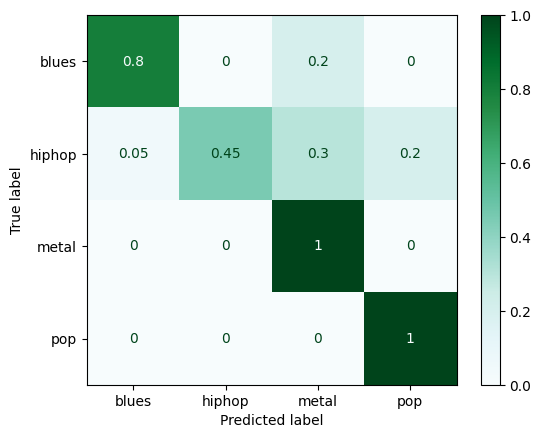

In [36]:
# Plotting the results
cm = confusion_matrix(real_lbl, predicted_lbl, normalize='true')
print(cm, end='\n\n')
print(classification_report(real_lbl, predicted_lbl, target_names=genres))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'hiphop', 'metal', 'pop'])
disp.plot(cmap='BuGn')
plt.show()

### Heatmaps
Although heatmaps don't differ relative to the previous section, we plot the once more here, with the exact same procedure.

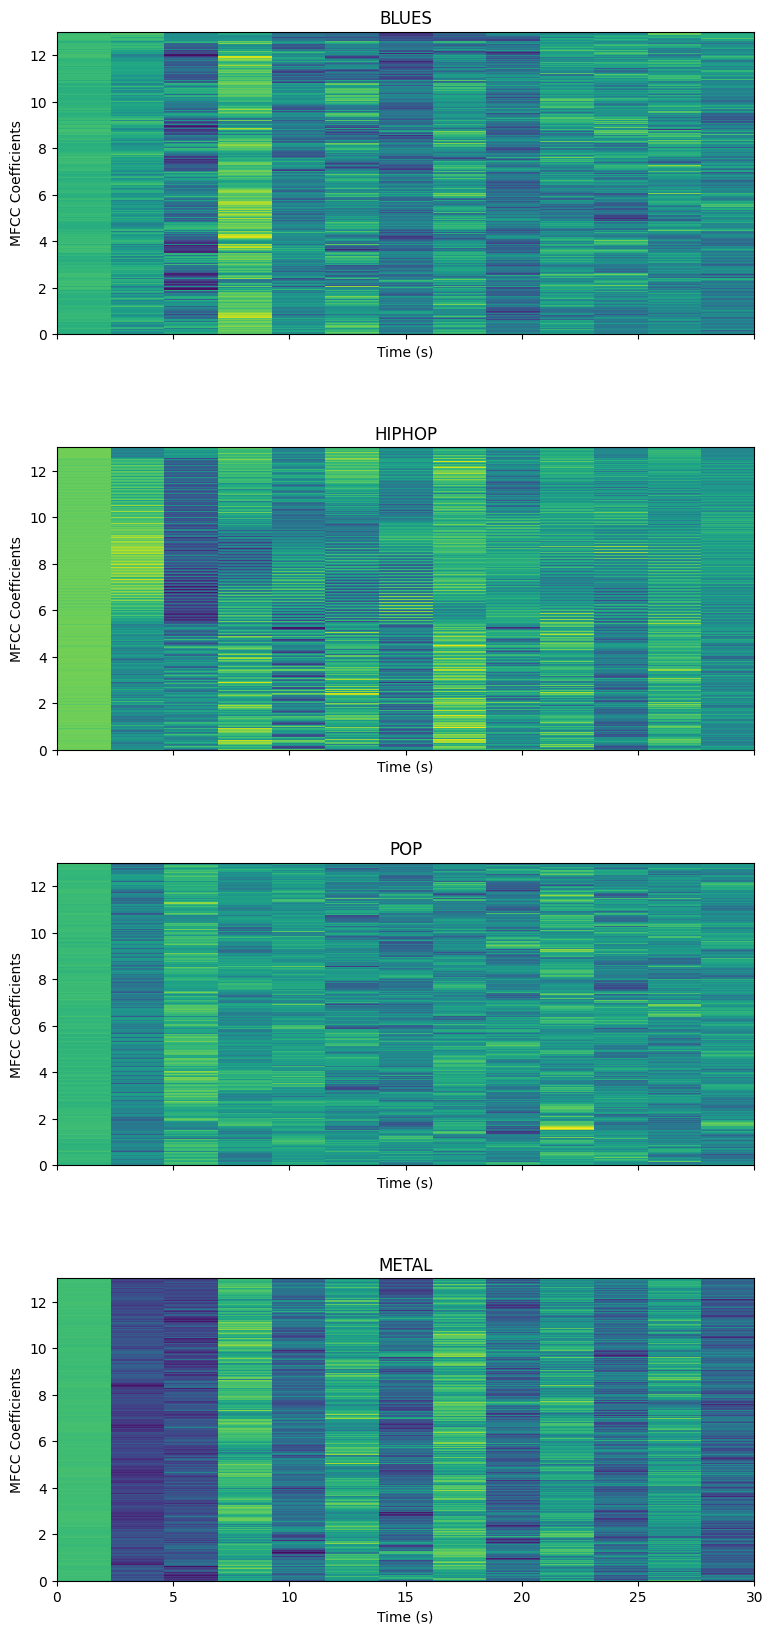

In [37]:
# Heatmap plots
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(9,27))

for i,genre in enumerate(genres):
    data = mfccs[genre][1]
    data = np.swapaxes(data, 0, 1)
    ax[i].imshow(data, interpolation='nearest', origin='lower', extent=[0, 30, 0, 13])
    ax[i].set_title(genre.upper())
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('MFCC Coefficients')

# Set the horizontal space between subplots
fig.subplots_adjust(top=0.7)

plt.show()

## Questions
#### part one:
1. > Because the HMM model is not a naturally dynamic entity so that it could change according to the size of the samples. HMMs are statistical models that create assumptions about temporal relationships within sequences. Having samples of the same length ensures that the model parameters are compatible across different sequences, making modeling and interpretation easier. Another advantage is that if the data to be modeled is constant, the code performance will improve because the data is assigned more optimal memory.
2. > The frames used in calculating MFCC overlap with each other to ensure that the end samples in the frame do not get attenuated due to windowing. The MFCC vector for this frame is less affected by these samples. These samples can be encoded in the next frame's MFCCs if the next frame has an overlap of at least 50%. Overlapping frames (at > 50%) increases redundancy in the MFCCs.
3. > In most audio-related projects, only the first 12 or 13 initial coefficients of MFCC are used because they contain the most relevant information about the audio signal. The zeroth coefficient is often excluded since it represents the average log-energy of the input signal, which only carries little speaker-specific information. The higher coefficients are also excluded to avoid complexity.

#### part two:
1. > In Hidden Markov Models (HMM), there are two types of variables: hidden states and observations. Hidden states are the underlying variables that generate the observed data, but they are not directly observable. Observations are the variables that are measured and observed. The relationship between the hidden states and the observations is modeled using a probability distribution. The HMM algorithm involves defining the state space, observation space, and the parameters of the state transition probabilities and observation likelihoods, training the model using the Baum-Welch algorithm or the forward-backward algorithm, decoding the most likely sequence of hidden states using the Viterbi algorithm, and evaluating the performance of the model. Here the observations are the MFCC Coefficients and the states might be words, sounds or parts of music.
2. > The reason for naming it First-Order is that the prediction of the next state is based solely on the current state, and no attention is paid to previous states. These first-order models assume that the next state is only dependent on the current state, meaning that the history that led to the current state is not important and is not considered. This feature is called memorylessness, which is one of the main characteristics of Markov processes.
>> Features of First-Order-HMM:
>> - The probability of transitioning from one state to the next depends only on the current state.
>> - The number of parameters required to define transitions is less than higher-order models, reducing complexity and the need for less training data.
>> - It has a simpler modeling and implementation compared to other HMM models.

>> Difference from other models in this classification:
>> - Higher-order models (Higher-Order HMMs): In these models, the next state can depend on several previous states. This means that if a second-order model is used, the current state and the previous state affect the determination of the next state. This allows for modeling of more temporal dependencies but with increased complexity and the need for more modeling data.
>> - Limited Dependency HMMs: These models may consider limited temporal dependencies, for example, they may only consider the last two or three states.
>> - Independent HMMs: Another type of model assumes that each state is independent of the other, which is usually not suitable for HMM models.

3. > Hidden Markov Models (HMM) are statistical models that are used to model sequential data, where the underlying process is assumed to be a Markov process with hidden states. HMMs have been applied in many fields where the goal is to recover a data sequence that is not immediately observable but other data that depend on the sequence are. Applications include speech recognition, handwriting recognition, gesture recognition, part-of-speech tagging, musical score following, and bioinformatics. The reason for the popularity of HMMs is that they are able to capture the temporal dependencies between observations and model the underlying process that generates the observations. HMMs are also relatively easy to implement and can be trained using the Baum-Welch algorithm or the forward-backward algorithm.
4. > Hidden Markov Models (HMM) have advantages and disadvantages that make them suitable for certain applications.  
>> Here are some of the advantages of HMM:
>> - HMMs can model sequential data, where the underlying process is assumed to be a Markov process with hidden states.
>> - HMMs can capture the temporal dependencies between observations and model the underlying process that generates the observations.
>> - HMMs are relatively easy to implement and can be trained using the Baum-Welch algorithm or the forward-backward algorithm.  
>> Here are some of the disadvantages of HMM:
>> - The Markov property assumes that future states depend only on the current state, which may not always be a realistic assumption for complex systems.
>> - HMMs can become computationally expensive as the number of states increases.
>> - HMMs often have a large number of unstructured parameters.
>> - First-order HMMs are limited by their first-order Markov property and cannot express dependencies between hidden states.
5. > There are different types of Hidden Markov Models (HMM) that are used for various applications.
>> Here are some of the most common types of HMMs:
>> - First-order HMMs: These models assume that the next state is only dependent on the current state and do not consider the history that led to the current state.
>> - Higher-order HMMs: These models allow the next state to depend on several previous states, which allows for modeling of more temporal dependencies but with increased complexity and the need for more modeling data.
>> - Limited Dependency HMMs: These models may consider limited temporal dependencies, for example, they may only consider the last two or three states.
>> - Independent HMMs: Another type of model assumes that each state is independent of the other, which is usually not suitable for HMM models 


<h4 style="color:grey; margin-left:8%;">by: <br> Mohammad Montazeri
<br>
810699269 </h4>